#CNN/LSTM models

In [1]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader
import time

Dowload data

In [48]:
drive.mount('/content/gdrive')

#import time series
datasets = {}
for name in ['sp500', 'eur_usd']:
    datasets[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/{name}_data.csv', index_col=0)
    datasets[name] = datasets[name]
    datasets[name].index.name = 'Date'
    datasets[name].index = pd.to_datetime(datasets[name].index)


Close_price = {}
Log_return = {}
residuals = {}
SARIMA_fitted_values = {}
SARIMA_test_predictions = {}

for name , dataset in datasets.items():

    #save Close price and Log Returns into a pd.Series
    Close_price[name] = dataset['Close'].copy().astype(float)
    # Log_return[name] = dataset['Log Return'].copy().astype(float)

    #drop columns not needed
    # dataset.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)
    dataset.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)


    #import SARIMA residuals
    residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_residuals.csv', index_col=0, sep=",")
    residuals[name].index = pd.to_datetime(residuals[name].index)

    #import SARIMA fitted values (predictions on the training set)
    SARIMA_fitted_values[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_fitted_values.csv', index_col=0)
    SARIMA_fitted_values[name].index = pd.to_datetime(SARIMA_fitted_values[name].index)

    #import SARIMA predictions on the test set
    SARIMA_test_predictions[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
    SARIMA_test_predictions[name].index = pd.to_datetime(SARIMA_test_predictions[name].index)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Helper functions to move data to the GPU

In [49]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in iter(self.dl):
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

##Univariate sliding windows

In [50]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)


train_data = {}
val_data = {}
train_val_data = {}
test_data = {}
scaler = {}
train_data_scaled = {}
val_data_scaled = {}
train_val_data_scaled = {}
test_data_scaled = {}

X_train = {}
X_val = {}
X_train_val = {}
X_test = {}
y_train = {}
y_val = {}
y_train_val = {}
y_test = {}


for name, dataset in datasets.items():

    #univariate sliding window
    train_data[name] = residuals[name].loc[: '2018']
    train_data[name].index = pd.to_datetime(train_data[name].index)

    val_data[name] = residuals[name].loc['2019': '2021']
    val_data[name].index = pd.to_datetime(val_data[name].index)

    train_val_data[name] = residuals[name].loc[: '2021']
    train_val_data[name].index = pd.to_datetime(train_val_data[name].index)

    test_data[name] = residuals[name].loc['2022':]
    test_data[name].index = pd.to_datetime(test_data[name].index)


    #scale the data
    scaler[name] = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
    train_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_data[name].values.reshape(-1, 1)))
    val_data_scaled[name] = pd.DataFrame(scaler[name].transform(val_data[name].values.reshape(-1, 1)))
    train_val_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_val_data[name].values.reshape(-1, 1)))
    test_data_scaled[name] = pd.DataFrame(scaler[name].transform(test_data[name].values.reshape(-1, 1)))


    #sliding windows
    X_train[name], y_train[name]  = sliding_windows(train_data_scaled[name], 10)
    X_val[name], y_val[name]= sliding_windows(val_data_scaled[name], 10)
    X_test[name], y_test[name] = sliding_windows(test_data_scaled[name], 10)
    X_train_val[name] , y_train_val[name] = sliding_windows(train_val_data_scaled[name], 10)

Covert data into tensor

In [51]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


train_df = {}
val_df = {}
train_val_df = {}
test_df = {}

train_loader = {}
val_loader = {}
train_val_loader = {}
test_loader = {}

for name, dataset in datasets.items():

    #istance of the custom dataset class
    train_df[name] = Custom_df(X_train[name], y_train[name])
    val_df[name] = Custom_df(X_val[name], y_val[name])
    train_val_df[name] = Custom_df(X_train_val[name], y_train_val[name])
    test_df[name] = Custom_df(X_test[name], y_test[name])


    #create dataloaders (to perform training/inference in batch)
    batch_size = 128
    num_workers = 2

    train_loader[name] = DataLoader(train_df[name], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader[name] = DataLoader(val_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    train_val_loader[name] = DataLoader(train_val_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_loader[name] = DataLoader(test_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


    #get device
    device = get_device()


    #move to device
    train_loader[name] = DeviceDataLoader(train_loader[name], device)
    val_loader[name] = DeviceDataLoader(val_loader[name], device)
    train_val_loader[name] = DeviceDataLoader(train_val_loader[name], device)
    test_loader[name] = DeviceDataLoader(test_loader[name], device)

##Neural network models

LSTM followed by CNN

In [52]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension


class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() #initialize the parent class
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        # out = out.squeeze(-1)
        # print(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    LSTM_CNN_model[name] = LSTM_CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_CNN_model[name].to(device) #move the istance to the device

CNN + LSTM parallel architecture

In [53]:
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
parallelCNNLSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    parallelCNNLSTM_model[name] = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    parallelCNNLSTM_model[name].to(device) #move the istance to the device

In [54]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 3

    LSTM_model[name] = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_model[name].to(device) #move the istance to the device

CNN model

In [55]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        out = self.fc(out_cnn)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    CNN_model[name] = CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    CNN_model[name].to(device) #move the istance to the device

##Training

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []
    # best_val_loss = float('inf') #initialized to the largest possible value
    # no_improve_count = 0  # Count epochs with no improvement in validation loss

    optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    annealing_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          patience=5, #defines how many epochs to wait for an improvement
                                                          factor =0.5 , #factor by which the learning rate will be reduced
                                                          min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                          eps=1e-08) #small value added to the learning rate for numerical stability

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            annealing_scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #scheduler.step(result['val_loss'])

        # if result['val_loss'] < best_val_loss:
        #     best_val_loss = result['val_loss']
        #     print(f"best vall loss: {best_val_loss}")
        #     no_improve_count = 0  # Reset counter on improvement
        # else:
        #     print(f"No improvement , current val loss: {result['val_loss']} best loss: {best_val_loss}")
        #     no_improve_count += 1  # Increment counter if no improvement


        model.epoch_end(epoch, result) #print results
        history.append(result)

        # if no_improve_count >= 50:
        #     print(f"No improvement in validation loss for {no_improve_count} epochs. Stopping training.")
        #     break

    return history

Train a single NN

warmup phase
Epoch [0], last_lr: 0.00004, train_loss: 0.3573, val_loss: 0.3611
Epoch [1], last_lr: 0.00006, train_loss: 0.2772, val_loss: 0.2764
Epoch [2], last_lr: 0.00008, train_loss: 0.1554, val_loss: 0.1732
Epoch [3], last_lr: 0.00010, train_loss: 0.0519, val_loss: 0.1216
Epoch [4], last_lr: 0.00012, train_loss: 0.0203, val_loss: 0.0768
Epoch [5], last_lr: 0.00014, train_loss: 0.0107, val_loss: 0.0567
Epoch [6], last_lr: 0.00016, train_loss: 0.0077, val_loss: 0.0479
Epoch [7], last_lr: 0.00018, train_loss: 0.0067, val_loss: 0.0416
Epoch [8], last_lr: 0.00020, train_loss: 0.0061, val_loss: 0.0366
Epoch [9], last_lr: 0.00022, train_loss: 0.0058, val_loss: 0.0329
Epoch [10], last_lr: 0.00024, train_loss: 0.0056, val_loss: 0.0301
Epoch [11], last_lr: 0.00026, train_loss: 0.0054, val_loss: 0.0283
Epoch [12], last_lr: 0.00028, train_loss: 0.0054, val_loss: 0.0269
Epoch [13], last_lr: 0.00030, train_loss: 0.0054, val_loss: 0.0265
Epoch [14], last_lr: 0.00032, train_loss: 0.0055, val_loss:

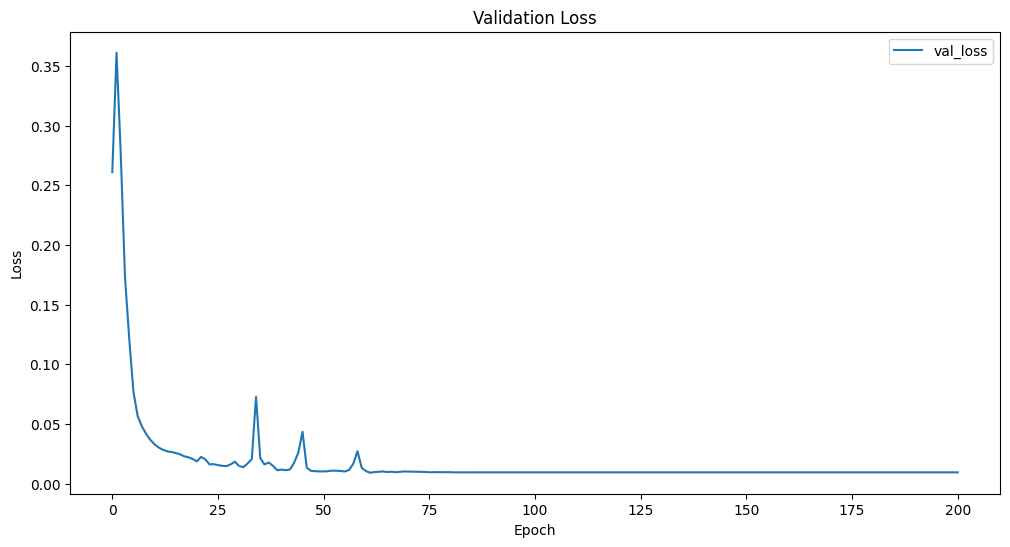

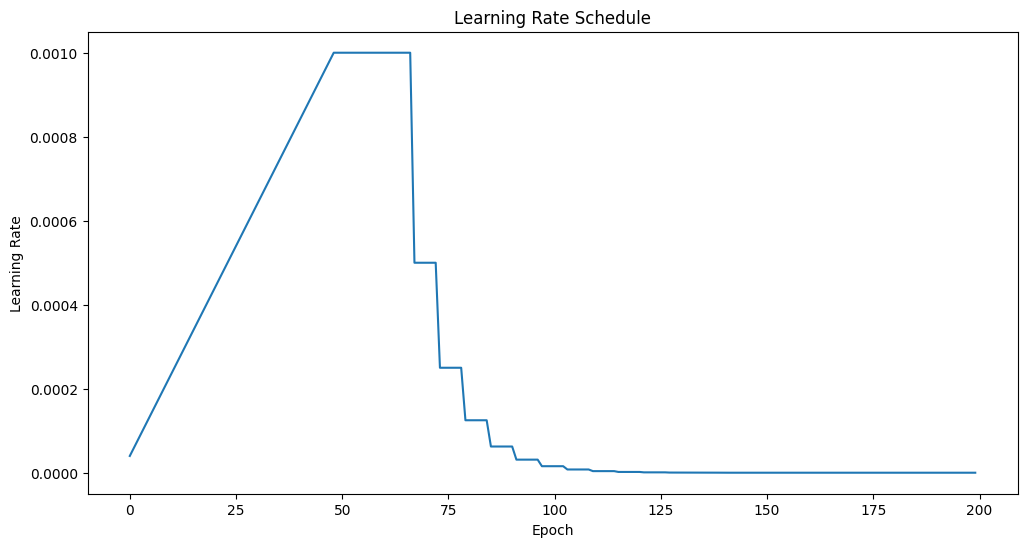

In [ ]:
#evaluate untrained model
history = [evaluate(CNN_model, test_loader)]


#train model
epochs = 200
warmup_epochs = 50
max_lr = 0.001
grad_clip = None
weight_decay = 1e-5
opt_func = torch.optim.Adam


start_time = time.time()
history += fit(epochs, max_lr, CNN_model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")


#visualize val_loss
plt.figure(figsize=(12, 6))
val_loss = [x['val_loss'] for x in history]
# train_loss = [x['train_loss'] for x in history[1:]]
plt.plot(val_loss)
# plt.plot(train_loss)
plt.legend(['val_loss', 'train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()


plt.figure(figsize=(12, 6))
lr = [x['lrs'] for x in history[1:]]
plt.plot(lr)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

Train all the NN models at once

training model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.3013, val_loss: 0.3183
Epoch [1], last_lr: 0.00010, train_loss: 0.1750, val_loss: 0.2132
Epoch [2], last_lr: 0.00013, train_loss: 0.1493, val_loss: 0.1859
Epoch [3], last_lr: 0.00017, train_loss: 0.1178, val_loss: 0.1709
Epoch [4], last_lr: 0.00020, train_loss: 0.0900, val_loss: 0.1346
Epoch [5], last_lr: 0.00023, train_loss: 0.0445, val_loss: 0.0742
Epoch [6], last_lr: 0.00027, train_loss: 0.0195, val_loss: 0.0581
Epoch [7], last_lr: 0.00030, train_loss: 0.0230, val_loss: 0.0556
Epoch [8], last_lr: 0.00033, train_loss: 0.0267, val_loss: 0.0603
Epoch [9], last_lr: 0.00037, train_loss: 0.0320, val_loss

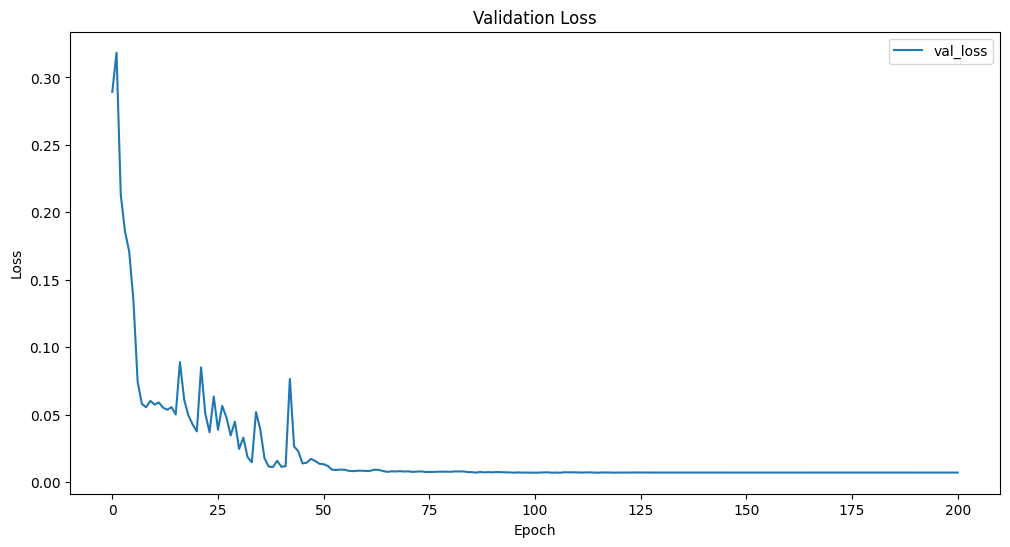

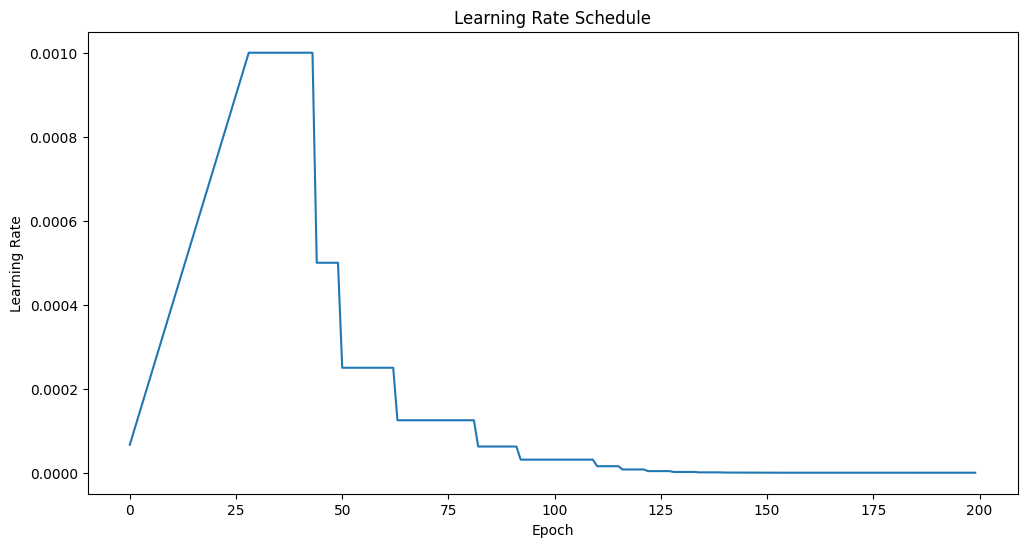

training model: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
warmup phase
Epoch [0], last_lr: 0.00005, train_loss: 0.2586, val_loss: 0.2736
Epoch [1], last_lr: 0.00007, train_loss: 0.1691, val_loss: 0.1911
Epoch [2], last_lr: 0.00010, train_loss: 0.0752, val_loss: 0.1268
Epoch [3], last_lr: 0.00013, train_loss: 0.0303, val_loss: 0.0815
Epoch [4], last_lr: 0.00015, train_loss: 0.0146, val_loss: 0.0503
Epoch [5], last_lr: 0.00017, train_loss: 0.0080, val_loss: 0.0406
Epoch [6], last_lr: 0.00

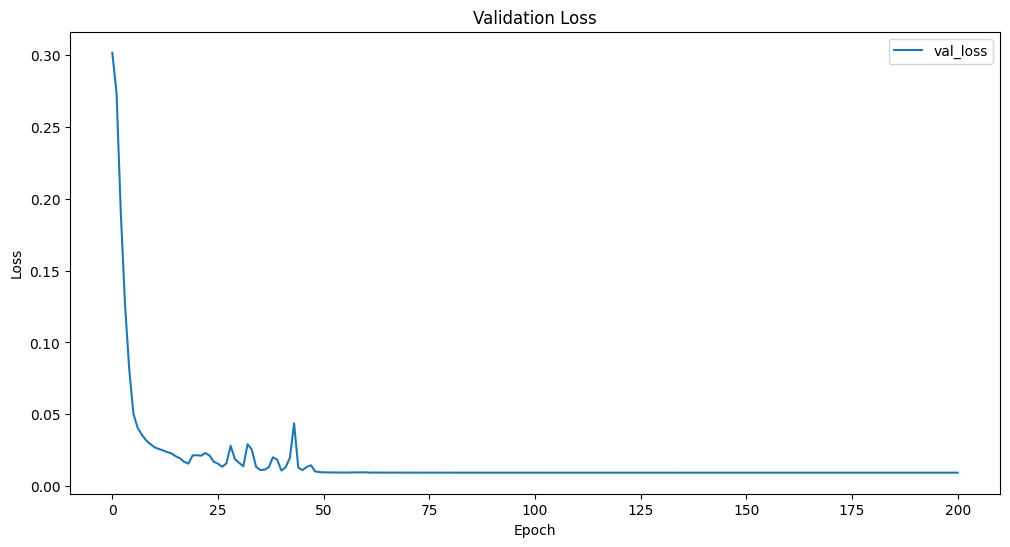

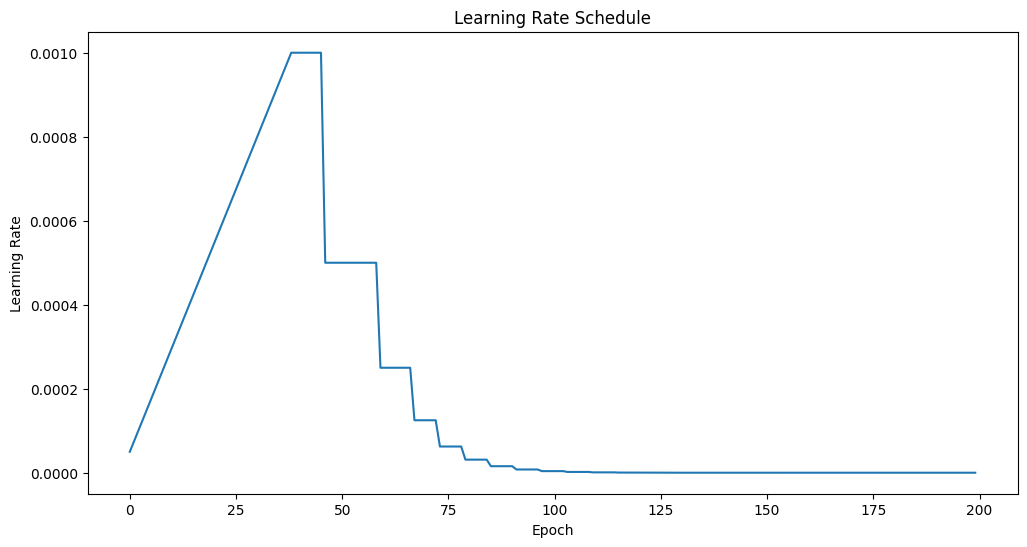

training model: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
warmup phase
Epoch [0], last_lr: 0.00010, train_loss: 0.1880, val_loss: 0.1824
Epoch [1], last_lr: 0.00015, train_loss: 0.0616, val_loss: 0.1240
Epoch [2], last_lr: 0.00020, train_loss: 0.0383, val_loss: 0.0773
Epoch [3], last_lr: 0.00025, train_loss: 0.0178, val_loss: 0.0484
Epoch [4], last_lr: 0.00030, train_l

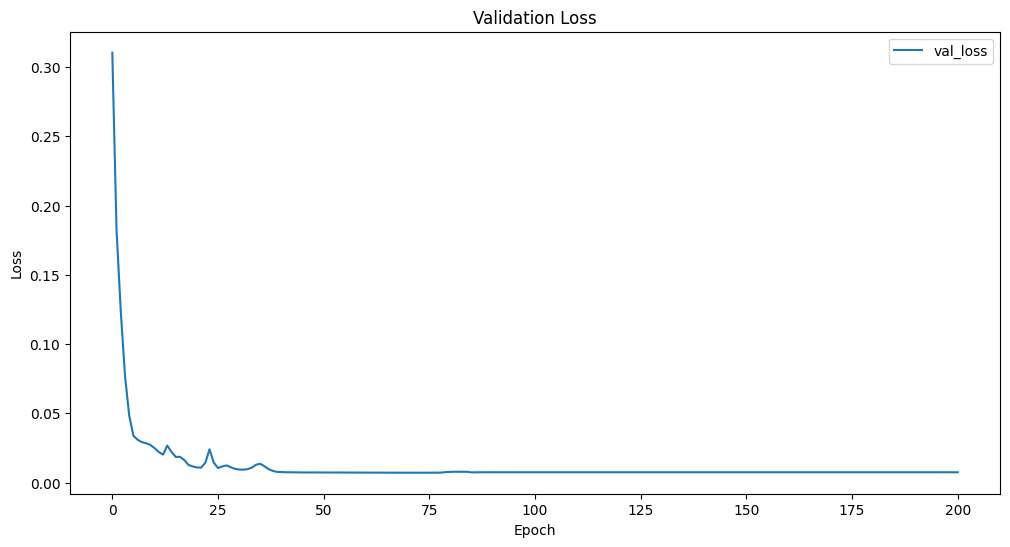

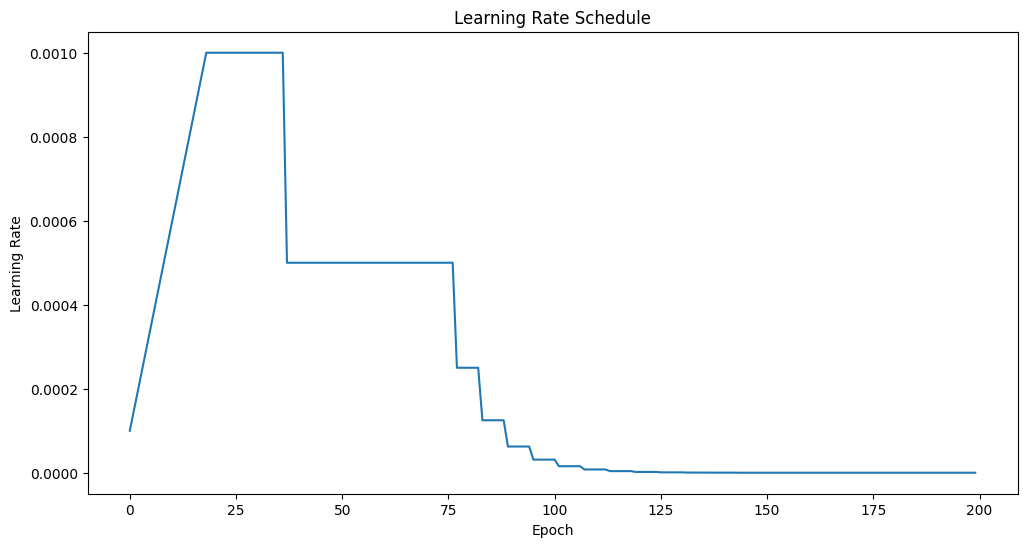

training model: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.2848, val_loss: 0.3126
Epoch [1], last_lr: 0.00010, train_loss: 0.2089, val_loss: 0.1871
Epoch [2], last_lr: 0.00013, train_loss: 0.0783, val_loss: 0.1622
Epoch [3], last_lr: 0.00017, train_loss: 0.0661, val_loss: 0.1438
Epoch [4], last_lr: 0.00020, train_loss: 0.0546, val_loss: 0.1158
Epoch [5], last_lr: 0.00023, train_loss: 

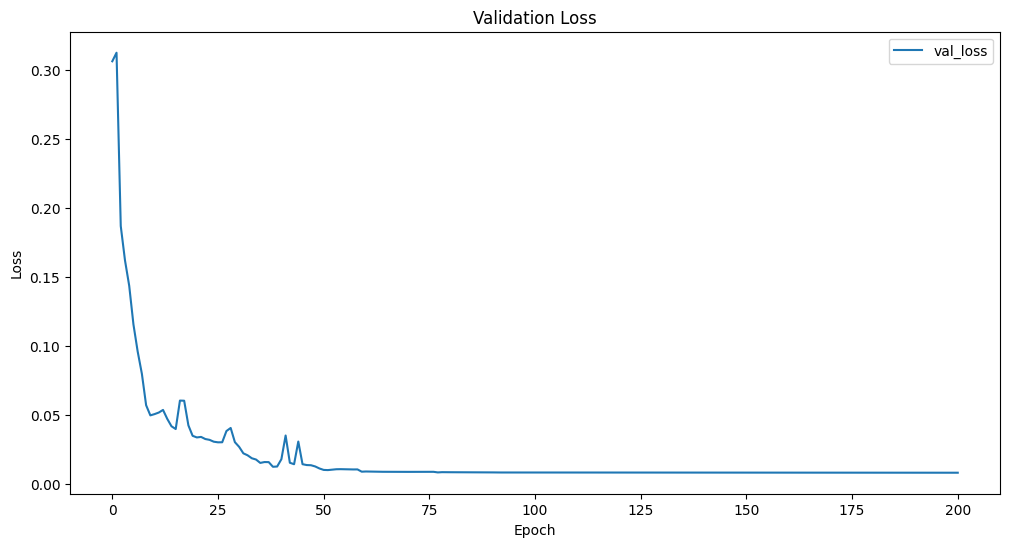

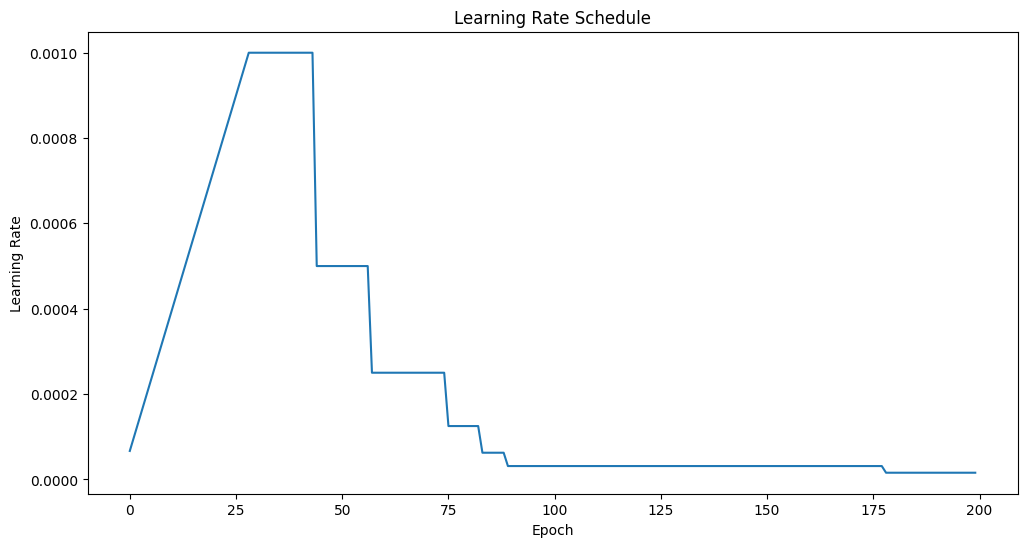

In [ ]:
import time
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for model in models:
    print(f"training model: {model}")
    #evaluate untrained model
    history = [evaluate(model, test_loader)]

    #train model
    if (model == parallelCNNLSTM_model):
        epochs = 200
        warmup_epochs = 20
    elif (model == LSTM_model):
        epochs = 200
        warmup_epochs = 30
    elif(model == CNN_model):
        epochs = 200
        warmup_epochs = 40
    elif(model ==LSTM_CNN_model):
        warmup_epochs = 30
        epochs = 200

    max_lr = 0.001
    grad_clip = None
    weight_decay = 1e-5
    opt_func = torch.optim.Adam


    start_time = time.time()
    history += fit(epochs, max_lr, model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")

    #visualize val_loss
    plt.figure(figsize=(12, 6))
    val_loss = [x['val_loss'] for x in history]
    # train_loss = [x['train_loss'] for x in history[1:]]
    plt.plot(val_loss)
    # plt.plot(train_loss)
    plt.legend(['val_loss', 'train_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()


    plt.figure(figsize=(12, 6))
    lr = [x['lrs'] for x in history[1:]]
    plt.plot(lr)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

##Save models state dict

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istances

for model in models:
    model_name = model.__class__.__name__
    save_path = f'/content/drive/MyDrive/università/Tesi/models/{model_name}'

    #save state dict of the model
    torch.save(model.state_dict(), save_path)

Mounted at /content/drive


Load models

In [56]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

model_names = ['LSTM', 'CNN', 'ParallelCNN_LSTM', 'LSTM_CNN']
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces


for model_name, model_istance in zip(model_names, models):
    model_path = f'/content/drive/MyDrive/università/Tesi/models/{model_name}'

    #load state dict
    for name , _ in datasets.items():
        model_istance[name].load_state_dict(torch.load(model_path, map_location=torch.device(device)))


Mounted at /content/drive


<ipython-input-56-8bd20e6a5ced>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_istance[name].load_state_dict(torch.load(model_path, map_location=torch.device(device

##Batch inference

In [57]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals

model sp500: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


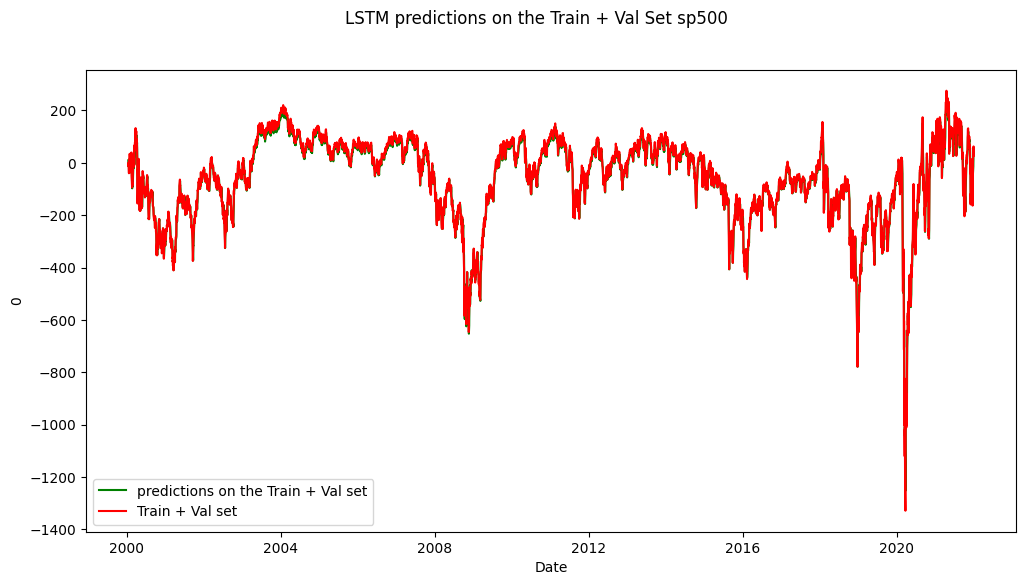

MSE: 515.8824032667766
RMSE: 22.713044781948028
MAE: 15.589247016562874
R2: 0.9799676564183674


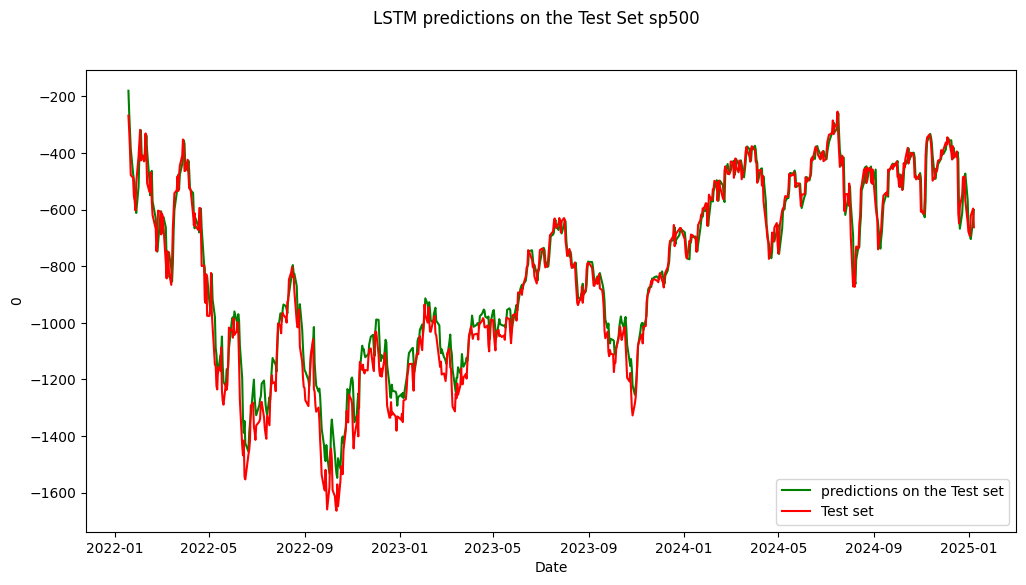

MSE: 3919.1378981357734
RMSE: 62.60301828295321
MAE: 46.95691698376809
R2: 0.9647134058698326
model sp500: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


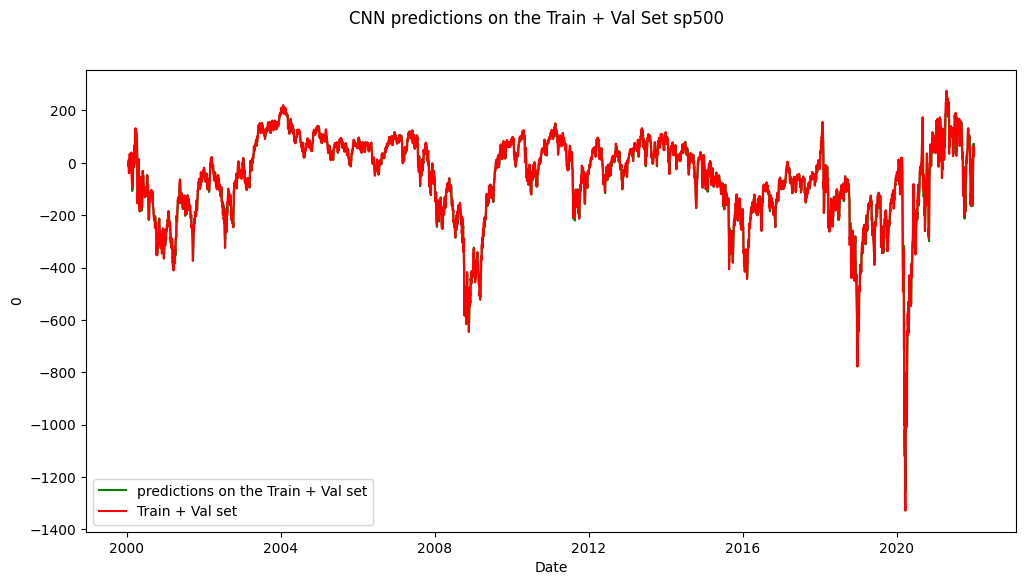

MSE: 536.4653012124517
RMSE: 23.161720601294967
MAE: 14.498831315724038
R2: 0.9791683973606006


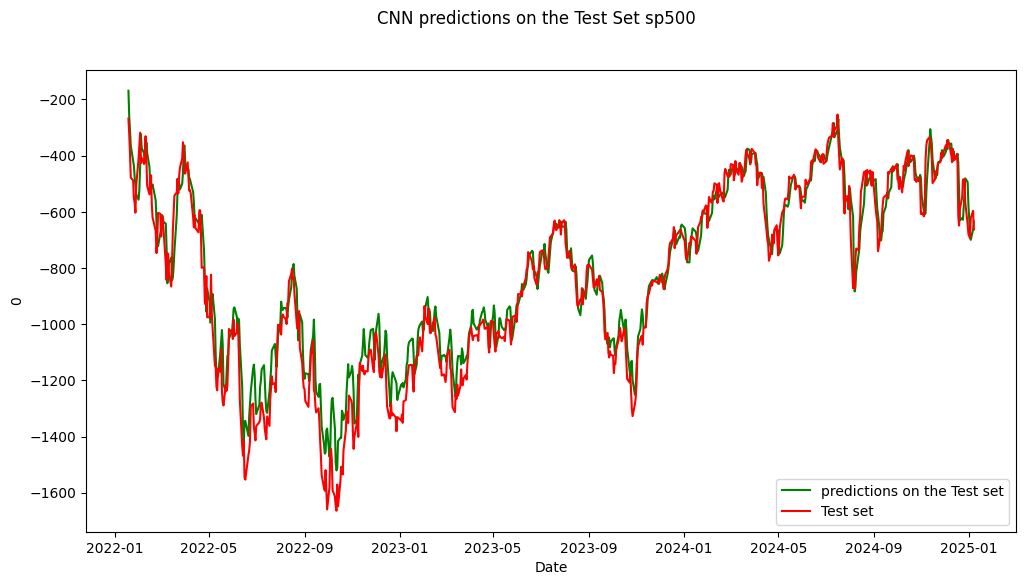

MSE: 6196.7311427471295
RMSE: 78.71931873909435
MAE: 58.8534725045649
R2: 0.9442067254454358
model sp500: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


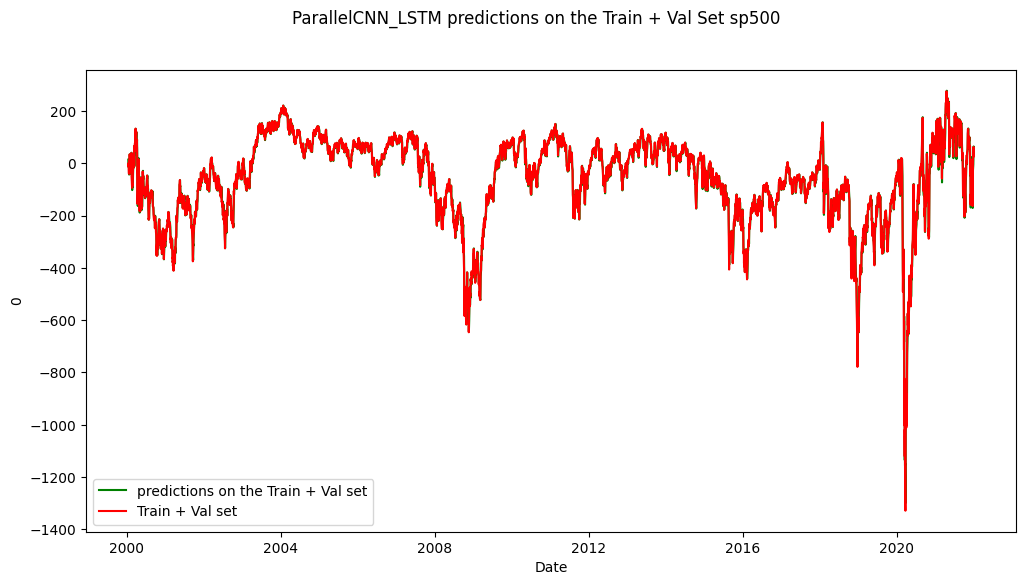

MSE: 476.10390054264917
RMSE: 21.81980523613007
MAE: 13.777153817741597
R2: 0.9815123042464123


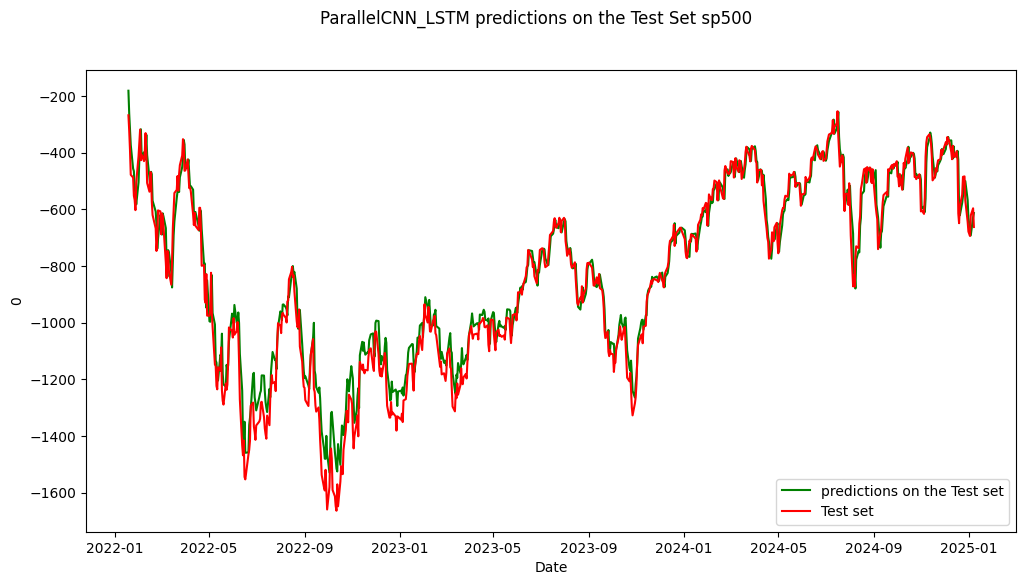

MSE: 4003.648145937771
RMSE: 63.274387756325
MAE: 47.60454384444259
R2: 0.963952504137988
model sp500: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


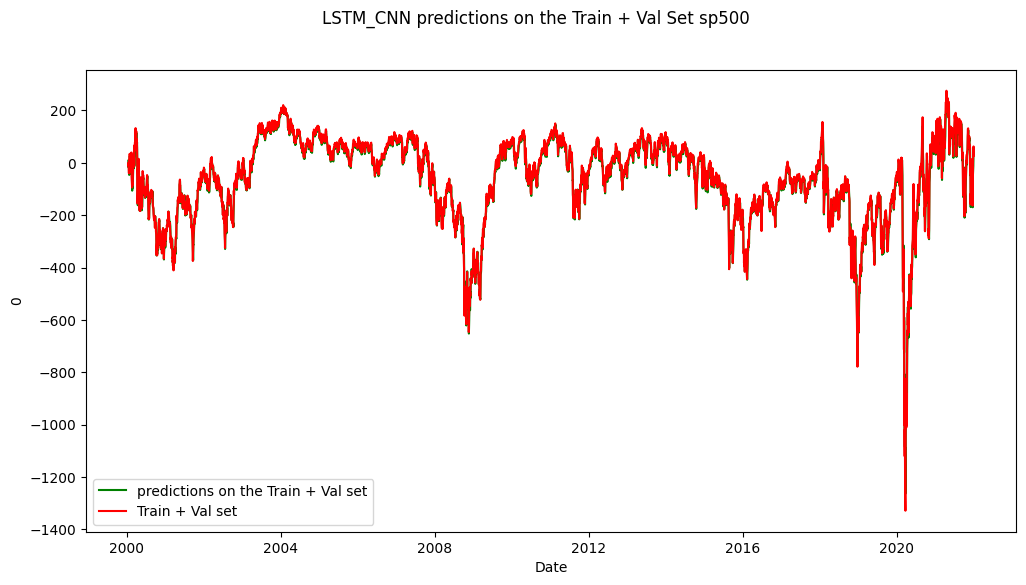

MSE: 510.24563981267204
RMSE: 22.58861748342895
MAE: 14.8466050462167
R2: 0.9801865388254547


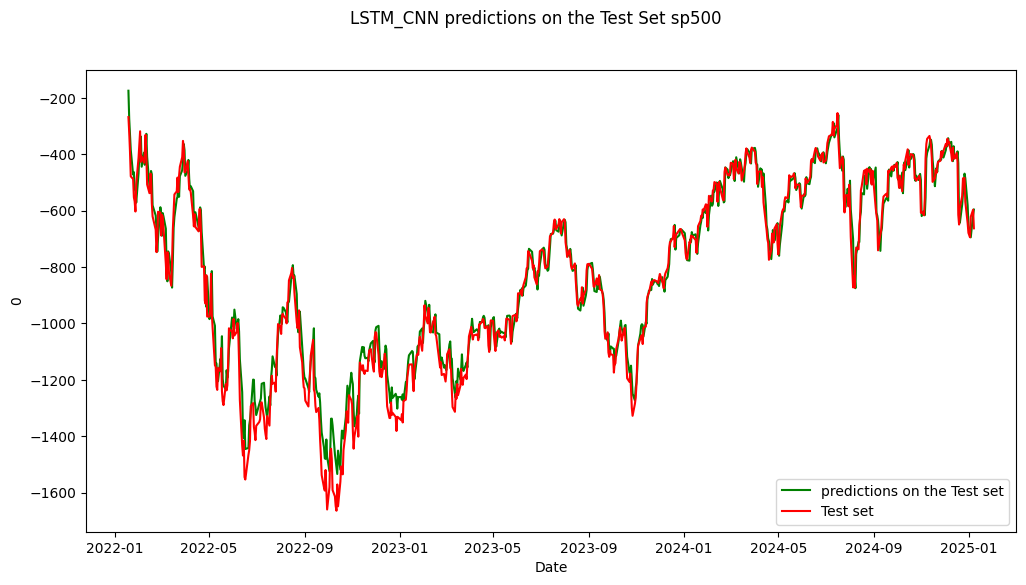

MSE: 3389.1089961550347
RMSE: 58.216054453690305
MAE: 43.57975302069291
R2: 0.9694856071109139
model eur_usd: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


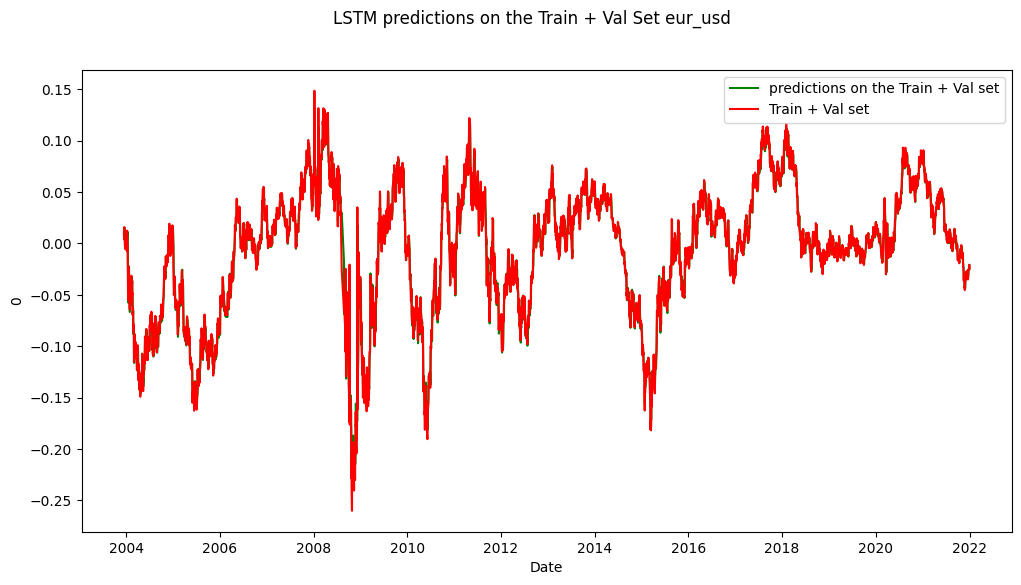

MSE: 9.594755083049724e-05
RMSE: 0.009795282069981304
MAE: 0.005888879518158106
R2: 0.9749775627376711


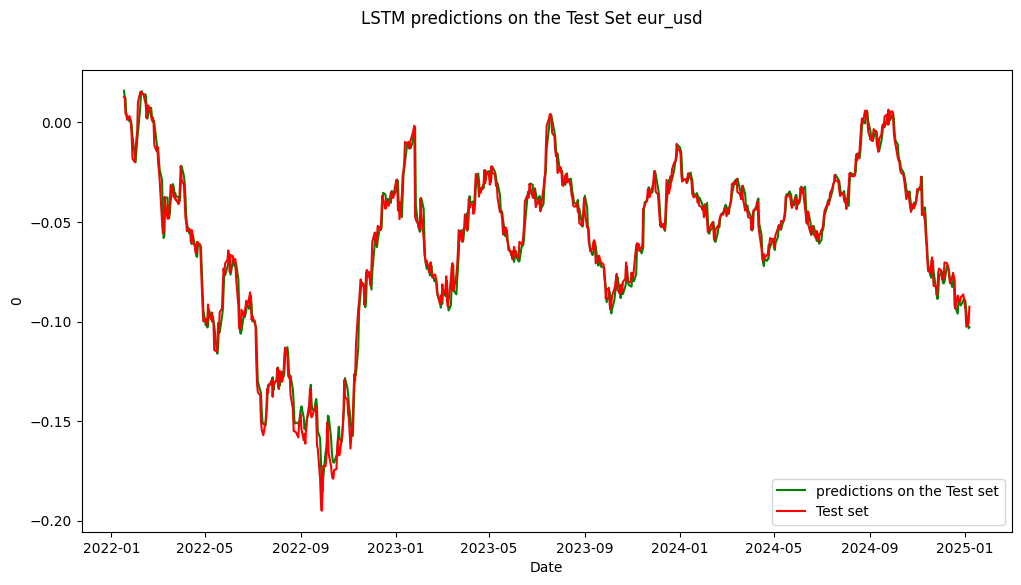

MSE: 3.5981899856229386e-05
RMSE: 0.005998491465045973
MAE: 0.0044426785133218636
R2: 0.9793390675307019
model eur_usd: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


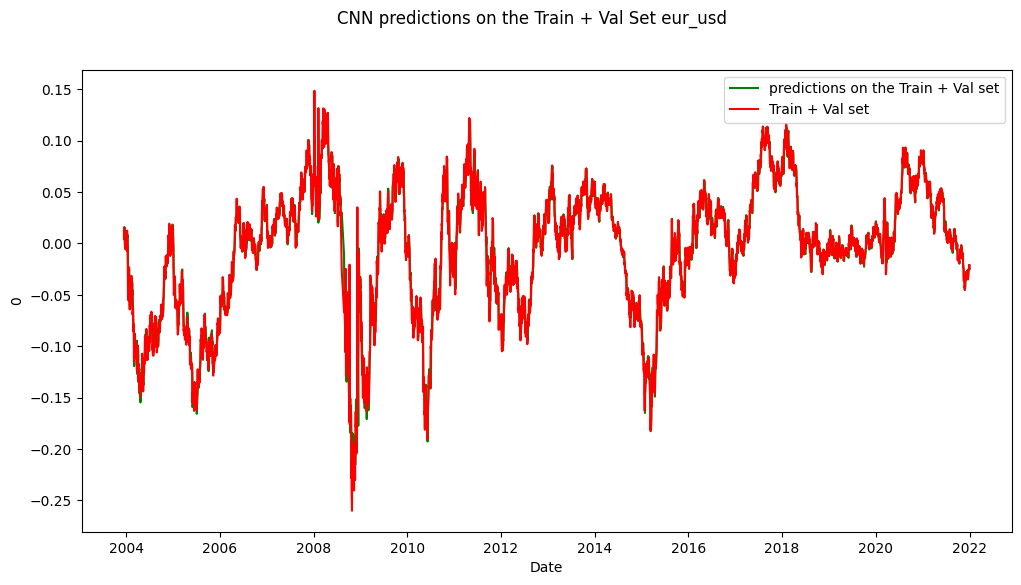

MSE: 9.782364028050003e-05
RMSE: 0.009890583414566606
MAE: 0.00631045978967916
R2: 0.9744882919834427


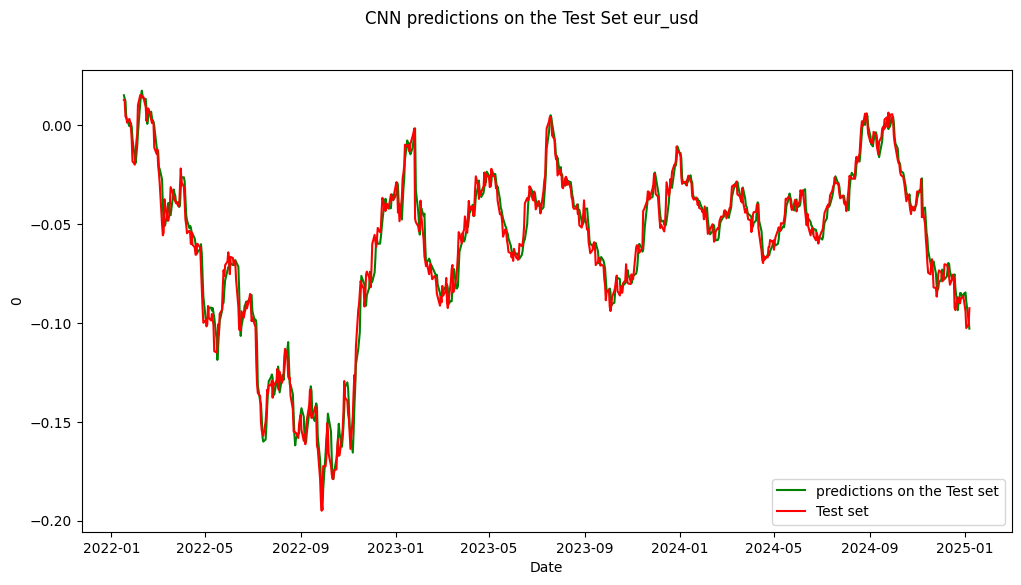

MSE: 4.606565889156816e-05
RMSE: 0.006787168694792267
MAE: 0.005026054503201172
R2: 0.9735489379016868
model eur_usd: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


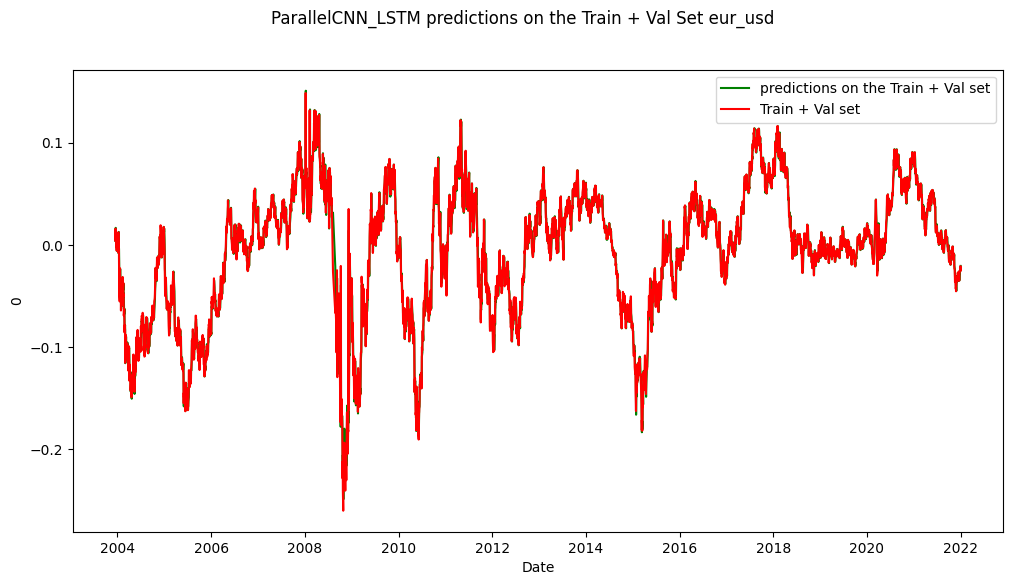

MSE: 9.568136491882481e-05
RMSE: 0.009781685177863006
MAE: 0.005856537426256645
R2: 0.9750469821258398


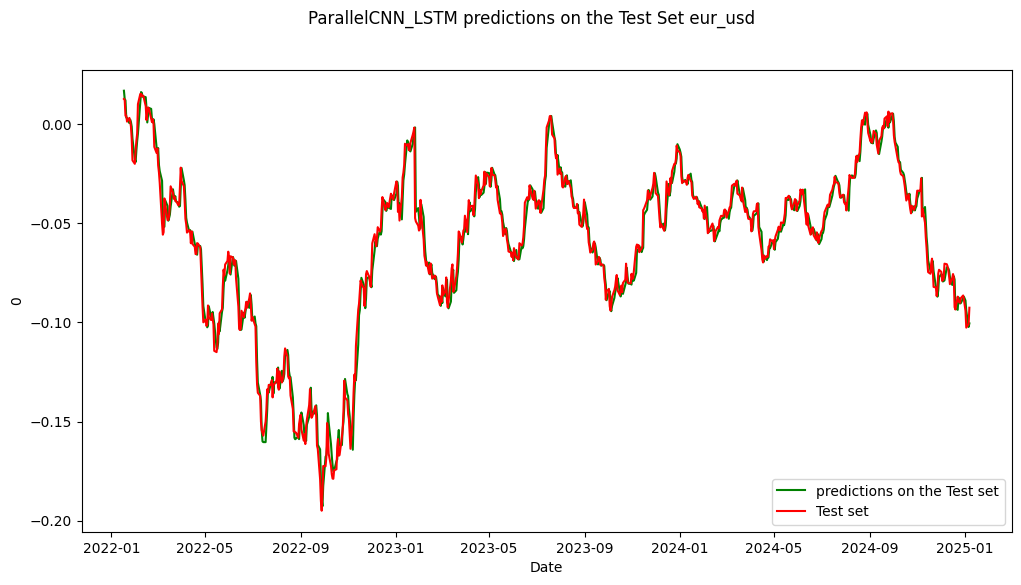

MSE: 3.3088122887319284e-05
RMSE: 0.00575222764564471
MAE: 0.004267328331052665
R2: 0.9810006843651313
model eur_usd: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


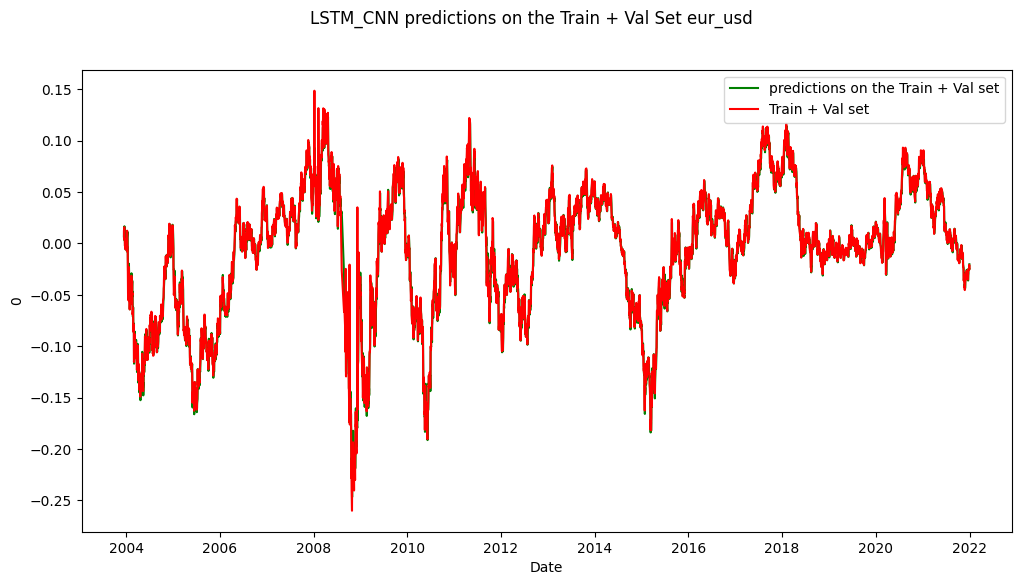

MSE: 8.396522167047654e-05
RMSE: 0.009163253880062287
MAE: 0.005863045359872682
R2: 0.9781024687625562


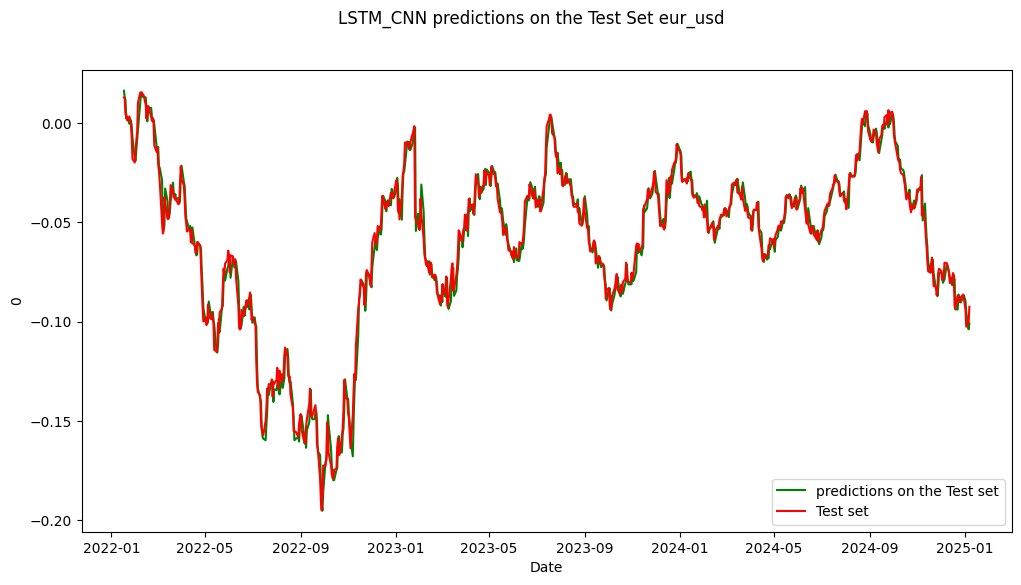

MSE: 3.2050994400980605e-05
RMSE: 0.005661359766079224
MAE: 0.004201540282982341
R2: 0.9815962071614218


In [58]:
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for name, _ in datasets.items():
    for model in models:
        print(f"model {name}: {model[name]}")
        model_name = model[name].__class__.__name__
        #batch inference
        prediction, actual = inference(model[name], test_loader[name])

        ## Inverse Scale
        prediction = scaler[name].inverse_transform(prediction)
        actual = scaler[name].inverse_transform(actual)


        #predictions on the test_loader
        prediction = pd.DataFrame(prediction)
        prediction.index = test_data[name][10:].index
        actual = pd.DataFrame(actual)
        actual.index = test_data[name][10:].index


        #predictions on the train_val_loader
        train_predictions, actual_train = inference(model[name], train_val_loader[name])

        ## Inverse Scale
        train_predictions = scaler[name].inverse_transform(train_predictions)
        actual_train = scaler[name].inverse_transform(actual_train)

        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.index = train_val_data[name][10:].index
        actual_train = pd.DataFrame(actual_train)
        actual_train.index = train_val_data[name][10:].index


        #visualize
        #predictions on the train + val set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions on the Train + Val set")
        sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train + Val set")
        plt.suptitle(f'{model_name} predictions on the Train + Val Set {name}')
        plt.show()


        #compute metrics
        mse = mean_squared_error(actual_train, train_predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual_train, train_predictions)
        r2 = r2_score(actual_train, train_predictions)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")


        #predictions on the Test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions on the Test set")
        sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "Test set")
        plt.suptitle(f'{model_name} predictions on the Test Set {name}')
        plt.show()


        #compute metrics
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, prediction)
        r2 = r2_score(actual, prediction)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")

##Combine ARIMA and NN predictions

sp500: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


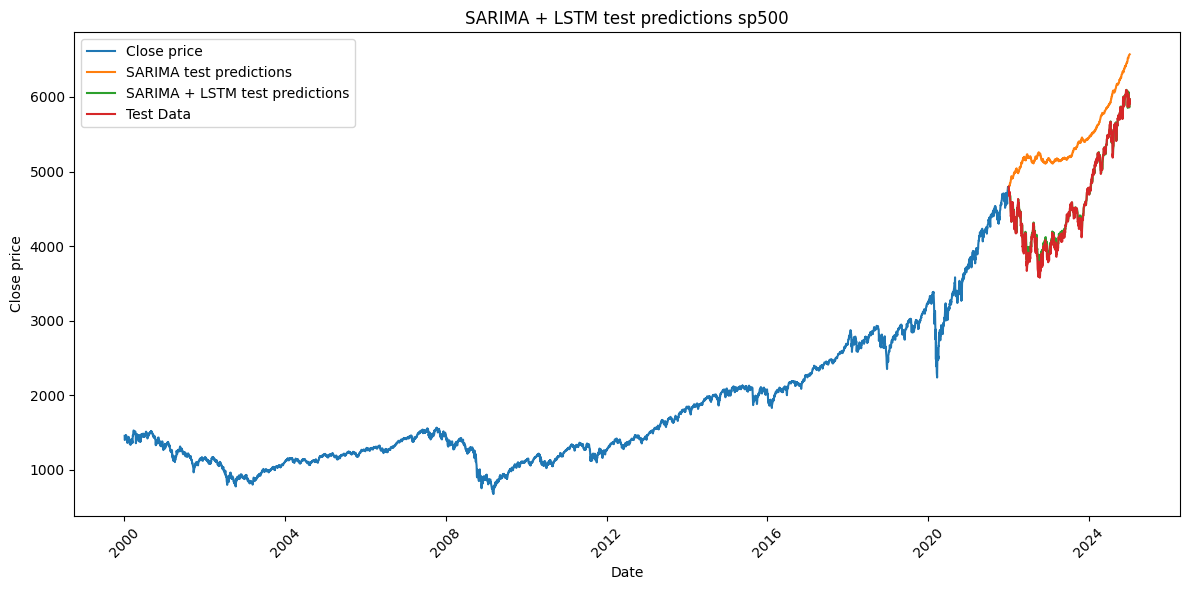

MSE: 3919.1378981357734
RMSE: 62.60301828295321
MAE: 46.95691698376809
R2: 0.9647134058698326


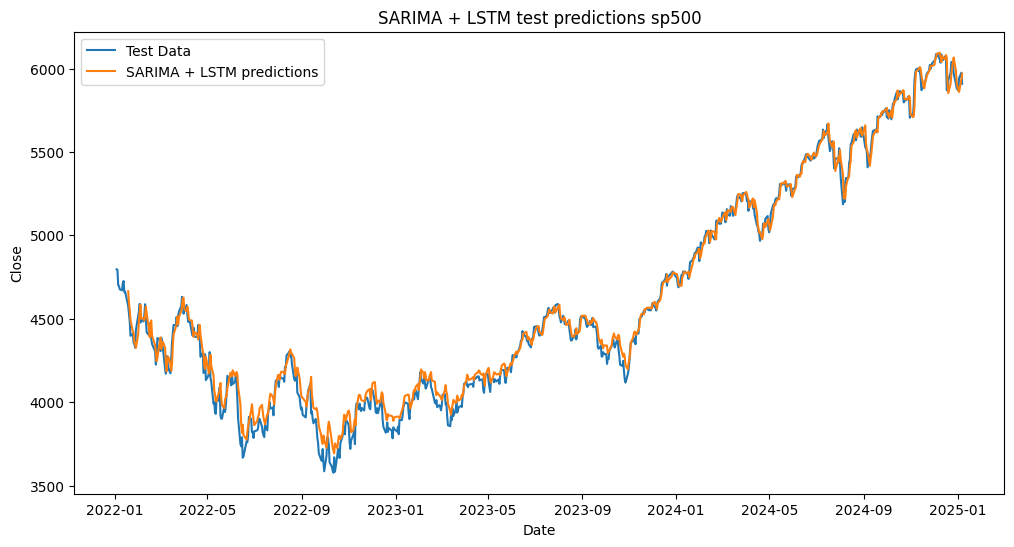

Mounted at /content/gdrive
sp500: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


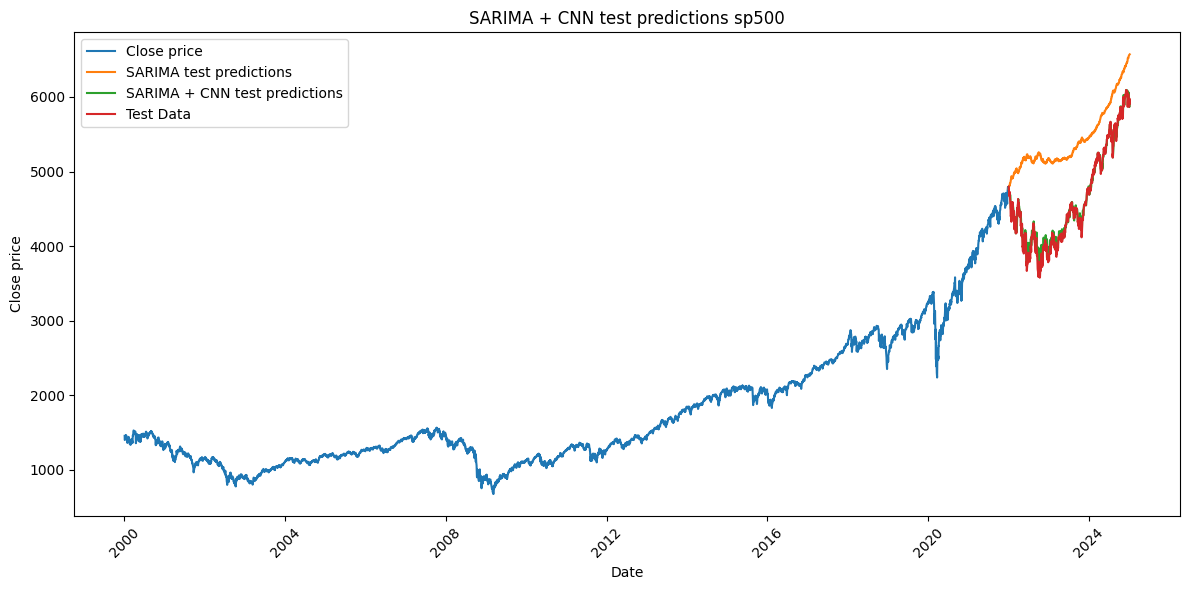

MSE: 6196.7311427471295
RMSE: 78.71931873909435
MAE: 58.8534725045649
R2: 0.9442067254454358


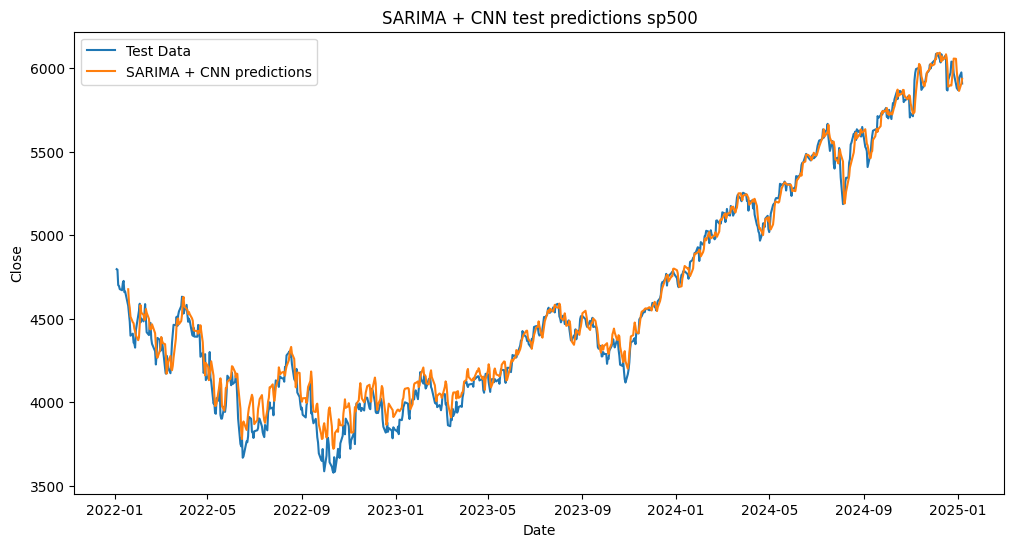

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
sp500: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


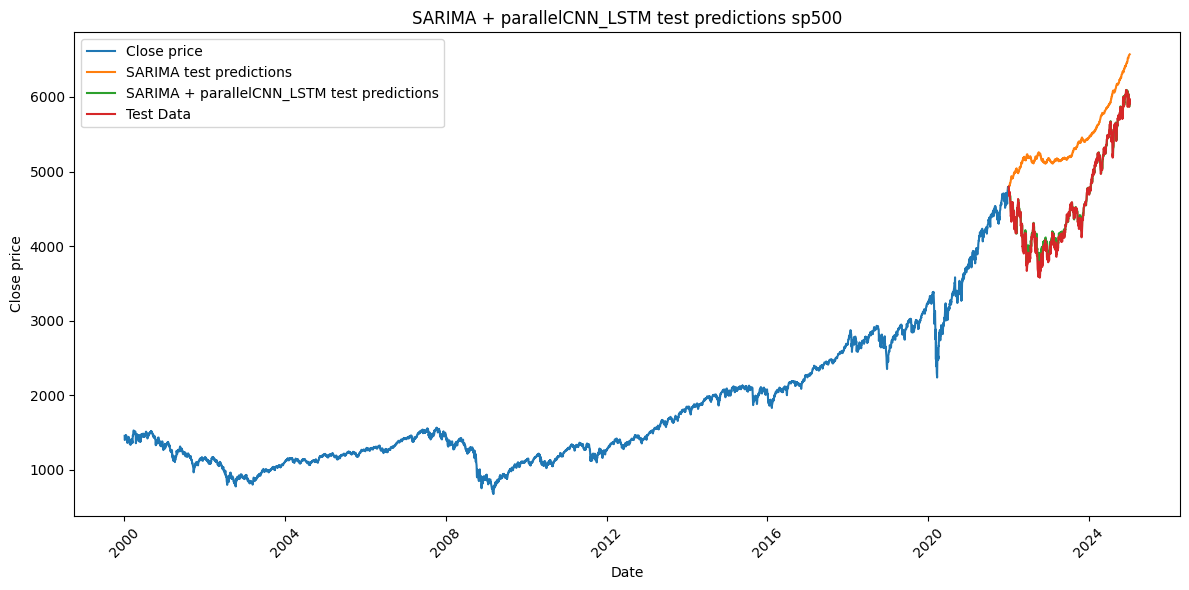

MSE: 4003.648145937771
RMSE: 63.274387756325
MAE: 47.60454384444259
R2: 0.963952504137988


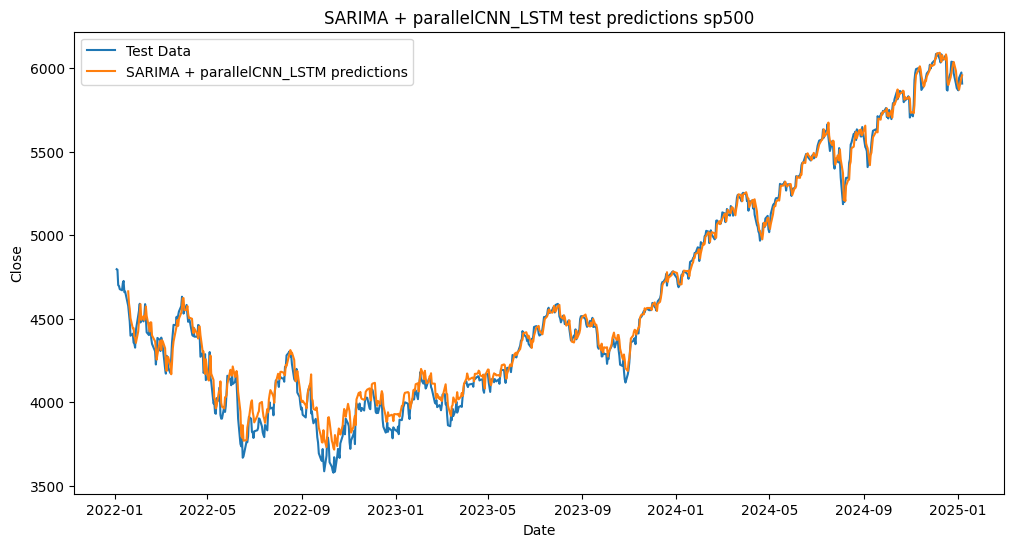

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
sp500: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
model_names = ['LSTM', 'CNN', 'parallelCNN_LSTM', 'LSTM_CNN'] #model names
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces

for name, _ in datasets.items():
    for model_name, model in zip(model_names, models):
        print(f"{name}: {model[name]}")

        #generate predictions
        prediction, actual = inference(model[name], test_loader[name])
        train_predictions, actual_train = inference(model[name], train_val_loader[name])

        #rescale predictions
        prediction = scaler[name].inverse_transform(prediction)
        actual = scaler[name].inverse_transform(actual)
        train_predictions = scaler[name].inverse_transform(train_predictions)
        actual_train = scaler[name].inverse_transform(actual_train)

        #set index
        prediction = pd.DataFrame(prediction)
        prediction.index = test_data[name][10:].index
        actual = pd.DataFrame(actual)
        actual.index = test_data[name][10:].index

        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.index = train_val_data[name][10:].index
        actual_train = pd.DataFrame(actual_train)
        actual_train.index = train_val_data[name][10:].index

        #combine arima and NN predictions on test set
        SARIMA_NN_test_predictions = SARIMA_test_predictions[name][10:] + prediction[0]

        #combine arima and NN predictions on train set
        SARIMA_NN_train_predictions = SARIMA_fitted_values[name].iloc[10:,0].values + train_predictions[0]


        #predictions on test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(data = Close_price[name].loc[train_val_data[name].index], label="Close price")
        sns.lineplot(x=test_data[name].index, y=SARIMA_test_predictions[name].values.ravel(), label="SARIMA test predictions")
        # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
        sns.lineplot(x=test_data[name].index[10:], y=SARIMA_NN_test_predictions, label= f"SARIMA + {model_name} test predictions")
        sns.lineplot(x=test_data[name].index, y=Close_price[name].loc[test_data[name].index ], label="Test Data")
        plt.title(f'SARIMA + {model_name} test predictions {name}')
        plt.xlabel('Date')
        plt.ylabel('Close price')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.tight_layout() # Automatically adjusts the layout
        plt.legend()
        plt.show()


        #compute metrics
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, prediction)
        r2 = r2_score(actual, prediction)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")


        #close up
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=test_data[name].index, y=Close_price[name].loc[test_data[name].index ], label="Test Data")
        sns.lineplot(x=test_data[name][10:].index, y=SARIMA_NN_test_predictions, label=f"SARIMA + {model_name} predictions")
        plt.title(f'SARIMA + {model_name} test predictions {name}')
        plt.show()


        #save ARIMA + XGBoost predictions
        drive.mount('/content/gdrive')
        file_path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/CNN LSTM/{name}/SARIMA_{model_name}_predictions.csv'
        SARIMA_NN_test_predictions = pd.Series(SARIMA_NN_test_predictions, index=test_data[name].index)
        SARIMA_NN_test_predictions.to_csv(file_path, index=True)
